In [7]:
from reliability.Distributions import Weibull_Distribution
from reliability.Fitters import Fit_Weibull_2P
from reliability.Probability_plotting import plot_points
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.figure import figaspect
import seaborn as sns
import numpy as np
import string

# Example

Results from Fit_Weibull_2P (95% CI):
Analysis method: Maximum Likelihood Estimation (MLE)
Optimizer: TNC
Failures / Right censored: 20/0 (0% right censored) 

Parameter  Point Estimate  Standard Error  Lower CI  Upper CI
    Alpha         28.1696         3.57032   21.9733   36.1131
     Beta         1.86308         0.32449   1.32428   2.62111 

Goodness of fit    Value
 Log-likelihood -79.5482
           AICc  163.802
            BIC  165.088
             AD  0.83728 



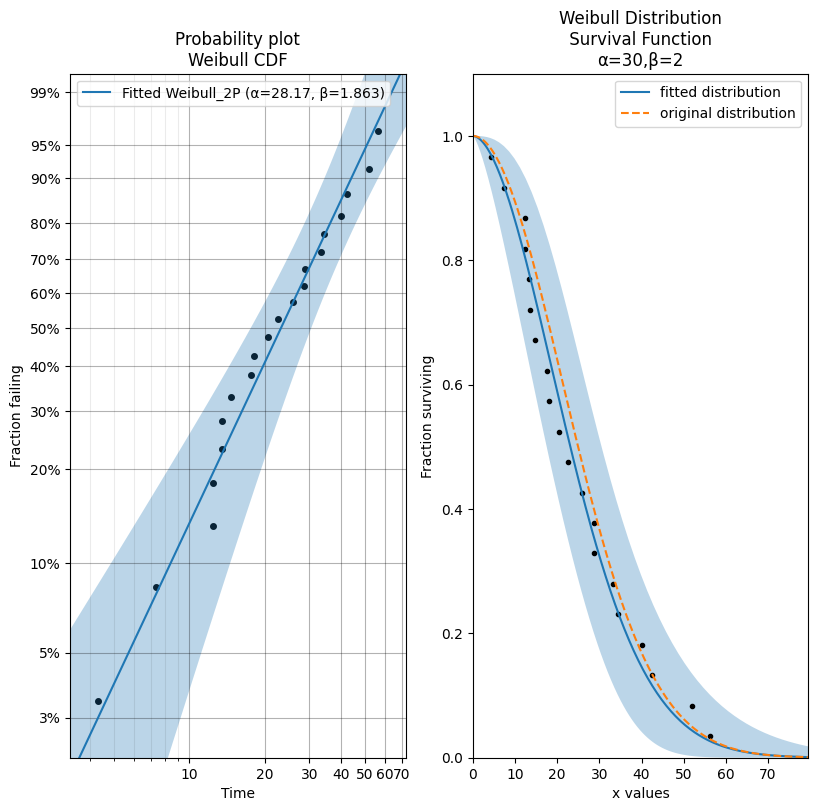

In [8]:
dist = Weibull_Distribution(alpha=30, beta=2)  # creates the distribution object
data = dist.random_samples(20, seed=42)  # draws 20 samples from the distribution. Seeded for repeatability
plt.subplot(121)
fit = Fit_Weibull_2P(failures=data)  # fits a Weibull distribution to the data and generates the probability plot
plt.subplot(122)
fit.distribution.SF(label='fitted distribution')  # uses the distribution object from Fit_Weibull_2P and plots the survival function
dist.SF(label='original distribution', linestyle='--') # plots the survival function of the original distribution
plot_points(failures=data, func='SF')  # overlays the original data on the survival function
plt.legend()
plt.show()

In [9]:
data

array([20.55094355, 52.04910458, 34.42486201, 28.66440822, 12.355662  ,
       12.35462111,  7.33858922, 42.54536142, 28.76063174, 33.28851237,
        4.32658956, 56.15337681, 40.09721423, 14.65670027, 13.43916254,
       13.50371358, 18.06871209, 25.87537532, 22.56065957, 17.60115602])

# 3.5mm Sample Test

In [10]:
test_data = pd.read_csv("Test_data.csv")

test_data

,Unnamed: 0,Proben-Nr.,Datum/Uhrzeit,Fcr,...,Moment,failure stress,Unnamed: 10,Diameter.1
0,NaN,NaN,NaN,N,...,Nmm,N/mm^2,NaN,mm
1,Probe 1,1,45420.6,22.85162354,...,342.8,76.7,NaN,3.57
2,Probe 2,2,45420.7,22.49817848,...,337.5,74.9,NaN,3.58
3,Probe 3,3,45420.7,18.44078827,...,276.6,62.4,NaN,3.56
4,Probe 4,4,45420.7,22.20804024,...,333.1,79.8,NaN,3.49
5,Probe 5,5,45420.7,23.90054512,...,358.5,83.7,NaN,3.52
6,Probe 6,6,45420.7,25.65187645,...,384.8,87.6,NaN,3.55
7,Probe 7,7,45420.7,26.03781509,...,390.6,87.4,NaN,3.57
8,Probe 8,8,45420.7,26.57203484,...,398.6,93.1,NaN,3.52
9,Probe 9,9,45420.7,18.93573761,...,284.0,65.8,NaN,3.53


In [11]:
"""
Cell generated by Data Wrangler.
"""
def clean_data(test_data):
    # Drop columns: 'Unnamed: 0', 'Unnamed: 10'
    test_data = test_data.drop(columns=['Unnamed: 0', 'Unnamed: 10'])
    # Drop rows with missing data in column: 'Proben-Nr.'
    test_data = test_data.dropna(subset=['Proben-Nr.'])
    # Change column type to uint32 for column: 'Proben-Nr.'
    test_data = test_data.astype({'Proben-Nr.': 'uint32'})
    # Rename column 'Proben-Nr.' to 'Probe_Num'
    test_data = test_data.rename(columns={'Proben-Nr.': 'Probe_Num'})
    return test_data

test_data_clean = clean_data(test_data.copy())
test_data_clean.head()

,Probe_Num,Datum/Uhrzeit,Fcr,Diameter,...,span,Moment,failure stress,Diameter.1
1,1,45420.6,22.85162354,3.57,...,30.0,342.8,76.7,3.57
2,2,45420.7,22.49817848,3.58,...,30.0,337.5,74.9,3.58
3,3,45420.7,18.44078827,3.56,...,30.0,276.6,62.4,3.56
4,4,45420.7,22.20804024,3.49,...,30.0,333.1,79.8,3.49
5,5,45420.7,23.90054512,3.52,...,30.0,358.5,83.7,3.52


In [12]:
fail_data = test_data_clean['failure stress'].to_numpy(dtype="float32")
fail_data

array([ 76.7,  74.9,  62.4,  79.8,  83.7,  87.6,  87.4,  93.1,  65.8,
        71.2,  71.6,  89.5, 101.6, 105. ,  74.3,  78. ,  92. ,  94.6,
        81.5,  73.4,  79. ,  89.7,  83.6,  86.5, 115.6,  81.6,  60.4,
        87.8,  86.3, 102. ,  72.4,  85.9], dtype=float32)

Results from Fit_Weibull_2P (95% CI):
Analysis method: Maximum Likelihood Estimation (MLE)
Optimizer: TNC
Failures / Right censored: 32/0 (0% right censored) 

Parameter  Point Estimate  Standard Error  Lower CI  Upper CI
    Alpha         88.9102         2.37043   84.3835   93.6797
     Beta         7.03417        0.893657   5.48368   9.02306 

Goodness of fit    Value
 Log-likelihood -127.101
           AICc  258.616
            BIC  261.133
             AD 0.963038 



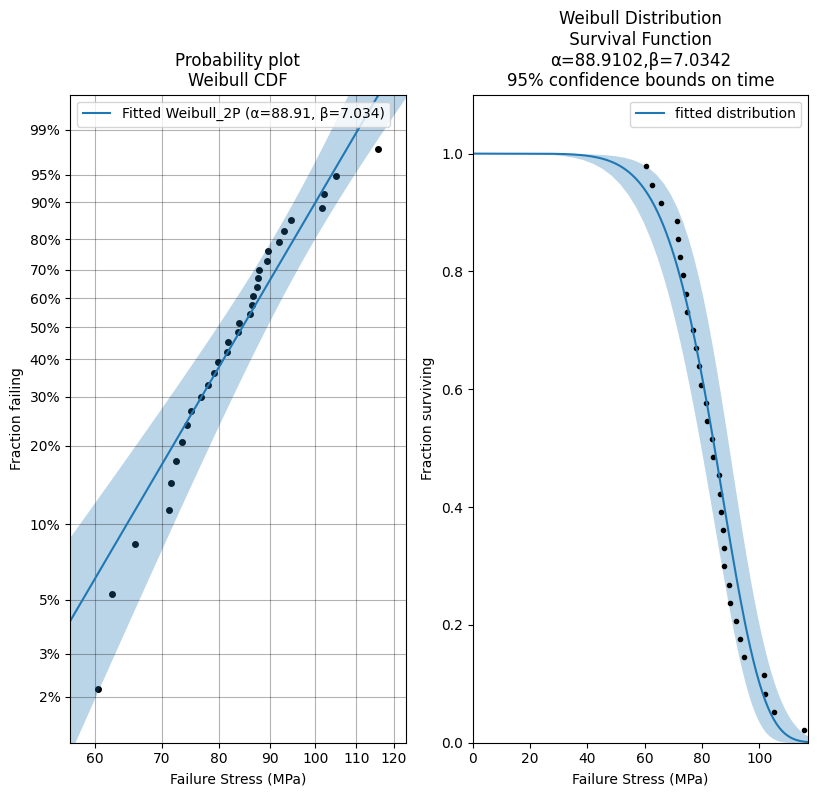

In [13]:
plt.clf()
plt.subplot(121)
test_fit = Fit_Weibull_2P(failures=fail_data)  # fits a Weibull distribution to the data and generates the probability plot
plt.xlabel("Failure Stress (MPa)")
plt.subplot(122)
test_fit.distribution.SF(label='fitted distribution')  # uses the distribution object from Fit_Weibull_2P and plots the survival function
plot_points(failures=fail_data, func='SF')  # overlays the original data on the survival function
plt.legend()
plt.xlabel("Failure Stress (MPa)")
plt.show()

array([0.1697135 , 0.37859694, 0.89833159])

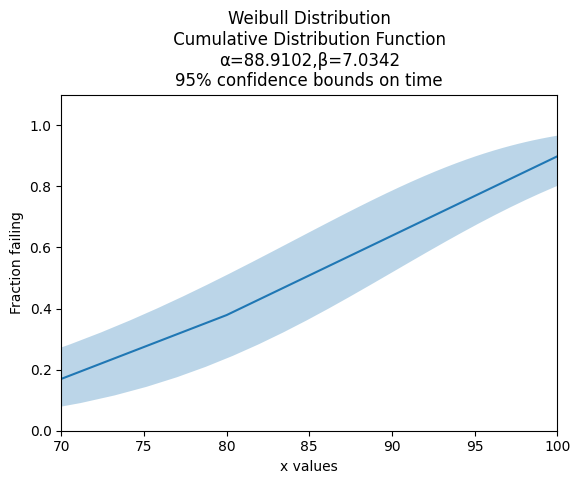

In [14]:
test_fit.distribution.CDF(xvals=[70, 80, 100])


# Full variation

## Load in and clean data

In [15]:
gcc_data = pd.read_csv("Maple Rod Testing Analysis.csv")

gcc_data

,Number,Fracture load,Fracture Stress,Fracture Diameter,Support Span,Load span,Surface Area,Volume
0,B1,46.7887,67.761,5.23,185,70,3039.65,3974.34
1,B2,85.8979,170.977,5.28,185,70,3068.71,4050.69
2,B3,54.1228,102.886,5.3,185,70,3080.33,4081.44
3,B4,64.6418,122.189,5.31,185,70,3086.14,4096.86
4,B5,78.9588,174.763,5.09,185,70,2958.28,3764.41
5,B6,57.2761,116.623,5.18,185,70,3010.59,3898.71
6,B7,68.1001,128.726,5.31,185,70,3086.14,4096.86
7,B8,80.9788,162.4,5.24,185,70,3045.46,3989.55
8,B9,56.073,108.539,5.22,185,70,3033.84,3959.16
9,B10,92.3955,179.794,5.32,185,70,3091.96,4112.3


In [16]:
"""
Cell generated by Data Wrangler.
"""
def clean_data(gcc_data):
    # Drop rows with missing data in column: 'Fracture Stress'
    gcc_data = gcc_data.dropna(subset=['Fracture Stress'])
    return gcc_data

gcc_data_clean = clean_data(gcc_data.copy())
gcc_data_clean.head()

,Number,Fracture load,Fracture Stress,Fracture Diameter,Support Span,Load span,Surface Area,Volume
0,B1,46.7887,67.761,5.23,185,70,3039.65,3974.34
1,B2,85.8979,170.977,5.28,185,70,3068.71,4050.69
2,B3,54.1228,102.886,5.3,185,70,3080.33,4081.44
3,B4,64.6418,122.189,5.31,185,70,3086.14,4096.86
4,B5,78.9588,174.763,5.09,185,70,2958.28,3764.41


In [ ]:
gcc_data_clean["Series"] = gcc_data_clean["Number"].str[0] ## Extract series letter from the "number" column

gcc_data_clean = gcc_data_clean.drop(gcc_data_clean[gcc_data_clean["Number"] == "D5"].index) ## Drop this outlier for now, remember to determine if this needs further inspection

gcc_data_clean

,Number,Fracture load,Fracture Stress,Fracture Diameter,Support Span,Load span,Surface Area,Volume,Series
0,B1,46.7887,67.761,5.23,185,70,3039.65,3974.34,B
1,B2,85.8979,170.977,5.28,185,70,3068.71,4050.69,B
2,B3,54.1228,102.886,5.3,185,70,3080.33,4081.44,B
3,B4,64.6418,122.189,5.31,185,70,3086.14,4096.86,B
4,B5,78.9588,174.763,5.09,185,70,2958.28,3764.41,B
5,B6,57.2761,116.623,5.18,185,70,3010.59,3898.71,B
6,B7,68.1001,128.726,5.31,185,70,3086.14,4096.86,B
7,B8,80.9788,162.4,5.24,185,70,3045.46,3989.55,B
8,B9,56.073,108.539,5.22,185,70,3033.84,3959.16,B
9,B10,92.3955,179.794,5.32,185,70,3091.96,4112.3,B


## Analyse data

In [19]:
gcc_data_anal = gcc_data_clean[["Fracture Diameter", "Series"]].groupby("Series").mean()

gcc_data_anal

,Fracture Diameter
Series,
B,5.248
C,1.6275
D,3.962
E,16.13
F,24.225
G,20.04
H,23.95
I,33.38
J,27


In [20]:
gcc_data_test = gcc_data_clean[gcc_data_clean["Number"].str.startswith("B")]["Fracture Stress"].to_numpy(dtype="float32")

In [22]:
unique_values = gcc_data_clean["Series"].unique()

In [23]:
w, h = figaspect(1.2)

for letter in unique_values:
    plot_data = gcc_data_clean[gcc_data_clean["Series"] == letter]["Fracture Stress"].to_numpy(dtype="float32")

    if len(plot_data) < 2: continue
    
    avg_diameter = gcc_data_anal.loc[letter, "Fracture Diameter"]
    legend_text = "%s Series: ~%.2f mm" % (letter, avg_diameter)
    
    fracture_fit = Fit_Weibull_2P(failures=plot_data, print_results="print_results", label=legend_text)  # fits a Weibull distribution to the data and generates the probability plot
   
    title_text = "Weibull probability\nScale= %.2f MPa  Shape= %.2f" % (fracture_fit.alpha, fracture_fit.beta)
    
    fig = fracture_fit.probability_plot.get_figure()
    fig.set_size_inches(w, h)
    plt.ylabel("Probability of failure")
    plt.xlabel("Failure Stress (MPa)")
    plt.title(title_text)
    plt.legend()
    # plt.subplot(122)
    # fracture_fit.distribution.SF(label='fitted distribution')  # uses the distribution object from Fit_Weibull_2P and plots the survival function
    # plot_points(failures=plot_data, func='SF')  # overlays the original data on the survival function
    
    # plt.xlabel("Failure Stress (MPa)")

    fig.savefig("Figs/Series_" + letter, bbox_inches = "tight")
    plt.clf()

    gcc_data_anal.loc[letter, "Alpha"] = fracture_fit.alpha
    gcc_data_anal.loc[letter, "Beta"] = fracture_fit.beta

<Figure size 400x480 with 0 Axes>

In [24]:
gcc_data_anal

,Fracture Diameter,Alpha,Beta
Series,,,
B,5.248,146.835,4.42583
C,1.6275,241.114,4.51885
D,3.962,134.145,8.76895
E,16.13,80.6672,11.4276
F,24.225,64.0356,6.8261
G,20.04,NaN,NaN
H,23.95,NaN,NaN
I,33.38,NaN,NaN
J,27,NaN,NaN


In [25]:
gcc_data_clean

,Number,Fracture load,Fracture Stress,Fracture Diameter,Support Span,Load span,Surface Area,Volume,Series
0,B1,46.7887,67.761,5.23,185,70,3039.65,3974.34,B
1,B2,85.8979,170.977,5.28,185,70,3068.71,4050.69,B
2,B3,54.1228,102.886,5.3,185,70,3080.33,4081.44,B
3,B4,64.6418,122.189,5.31,185,70,3086.14,4096.86,B
4,B5,78.9588,174.763,5.09,185,70,2958.28,3764.41,B
5,B6,57.2761,116.623,5.18,185,70,3010.59,3898.71,B
6,B7,68.1001,128.726,5.31,185,70,3086.14,4096.86,B
7,B8,80.9788,162.4,5.24,185,70,3045.46,3989.55,B
8,B9,56.073,108.539,5.22,185,70,3033.84,3959.16,B
9,B10,92.3955,179.794,5.32,185,70,3091.96,4112.3,B


[Text(0.5, 0, 'Diameter (mm)'),
 Text(0, 0.5, 'Scale (MPa)'),
 Text(0.5, 1.0, 'Weibull scale parameter vs. Diameter')]

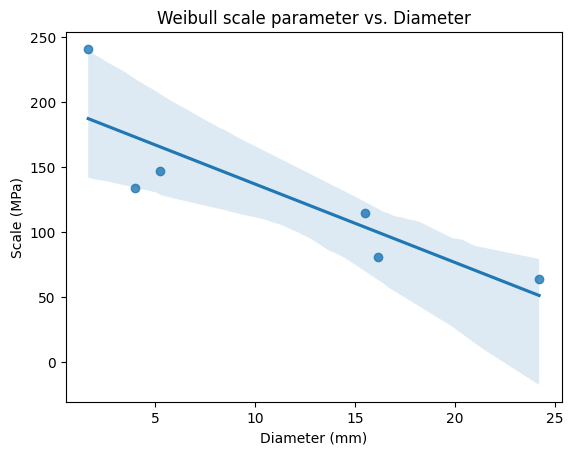

In [26]:
ax = sns.regplot(data=gcc_data_anal, x="Fracture Diameter", y="Alpha")
ax.set(xlabel="Diameter (mm)", ylabel="Scale (MPa)", title="Weibull scale parameter vs. Diameter")


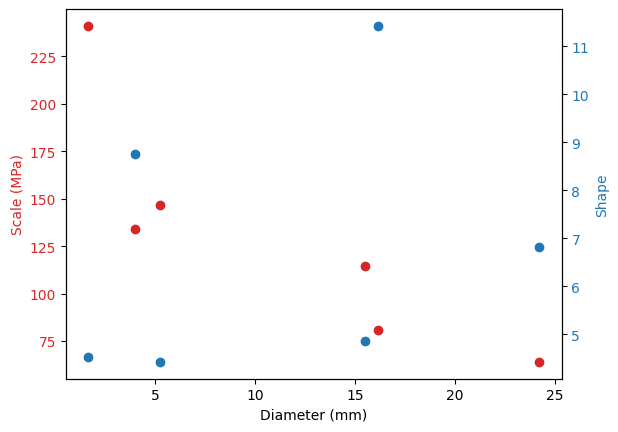

In [27]:
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel("Diameter (mm)")
ax1.set_ylabel('Scale (MPa)', color=color)
ax1.scatter("Fracture Diameter", "Alpha", data=gcc_data_anal.dropna(), color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()

color = 'tab:blue'
ax2.set_ylabel('Shape', color=color)  # we already handled the x-label with ax1
ax2.scatter("Fracture Diameter", "Beta", data=gcc_data_anal.dropna(), color=color)
ax2.tick_params(axis='y', labelcolor=color)

# Size effect normalisation plot

In [28]:
standard_SA = np.pi * 3.0 * 185.0
standard_V = np.pi * pow((3.0 / 2.0), 2)

In [29]:
def size_effect_normalize(original_prob, original_size, standard_size):
    size_ratio = standard_size / original_size
    return 1 - (1 - original_prob)**size_ratio

In [30]:
size_effect_normalize(0.5, 2, 4)

0.75